In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from anndata import AnnData
sc.settings.verbosity = 3
from scipy.sparse import csc_matrix
from anndata import AnnData


from tqdm import tqdm
import os 
import importlib
import sys
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.sans-serif'] = 'Arial'
sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
# sns.set_style('white', {'axes.grid' : False})
sys.path.append('/storage/liuyi/00.SNP_project/jupyter/bin')
import spatialSNV_r as ss
importlib.reload(ss)
def vector(on=False):
    if on:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=False)
    else:
        sc.set_figure_params(dpi=50, dpi_save=300, vector_friendly=True)
vector(False)

from scipy.sparse import save_npz, load_npz
def get_min_distance(adata):
    locations = adata.obsm['spatial'].copy()
    distances = np.linalg.norm(locations[:, np.newaxis] - locations, axis=2)
    np.fill_diagonal(distances, np.inf)
    min_distances = np.min(distances, axis=1)
    average_min_distance = np.mean(min_distances)
    return average_min_distance

def _normalize_data(X, counts, after= None):
    from sklearn.utils.sparsefuncs import inplace_row_scale
    X = X.copy()
    after = np.median(counts_greater_than_zero, axis=0) if after is None else after
    counts += counts == 0
    counts = counts / after
    inplace_row_scale(X, 1 / counts)
    return X

In [3]:
import gseapy as gp

In [4]:
sample = 'CRC-P59-T_1'

In [5]:
snv = sc.read_h5ad(f'../../SNV_process/norm/{sample}.norm_snv.h5ad')
rna = sc.read_h5ad(f'../../RNA_cluster/{sample}.rna.h5ad')

In [5]:
snv_df = snv.to_df().T
window_size = 100000
snv_df['chrom'] = snv_df.index.map(lambda x: x.split('_')[0])
snv_df['num'] = snv_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv_df['windows'] = snv_df['chrom'] +'@'+ snv_df['num']
del snv_df['chrom']
del snv_df['num']
snv_df = snv_df.groupby('windows').sum().T
snv_gene_adata = AnnData(snv_df)
snv_gene_adata.X = csc_matrix(snv_gene_adata.X)
snv_gene_adata.obsm['spatial'] = snv.obsm['spatial']

In [6]:
snv_gene_adata.obs['cluster'] = rna.obs['cluster']
snv_gene_adata = snv_gene_adata[snv_gene_adata.obs['cluster']!='Normal'].copy()
sc.pp.filter_genes(snv_gene_adata,min_cells=1)

In [7]:
radius = get_min_distance(snv_gene_adata)
ss_con = ss.build_connect(snv_gene_adata, radius = 5 * (radius), include_self=False, norm=True, scaling=False, rank2=False,
                          rank_cutoff = 50, n_neighbors = 30, use_raw=False, decay='Gaussian')

/storage/liuyi/00.SNP_project/jupyter/bin/spatialSNV_r.py:88: RuntimeWarning: divide by zero encountered in divide
  scalers = 1 / scalers


Step1: cell-cell connectivity calculation finished, Wed May 29 14:00:30 2024
Step2: ranking SNV expression values finished, Wed May 29 14:00:39 2024


/storage/liuyi/00.SNP_project/jupyter/bin/spatialSNV_r.py:152: RuntimeWarning: divide by zero encountered in divide
  scaler_mode = 1/mode


Step3: cell-SNV connectivity calculation finished, Wed May 29 14:00:41 2024
Step5: SNV-SNV connectivity calculation finished, Wed May 29 14:00:43 2024


In [8]:
snv_gene_adata,ac = ss.build_sg(snv_gene_adata, con = ss_con,resolution = 10, syn = False)

In [9]:
ac.write('crct1.ac.h5ad')

In [333]:
# snv_gene_adata.write('crct1.snv_gene_adata.h5ad')

In [335]:
# from scipy.sparse import save_npz
# save_npz('ss_con_matrix.npz', ss_con)

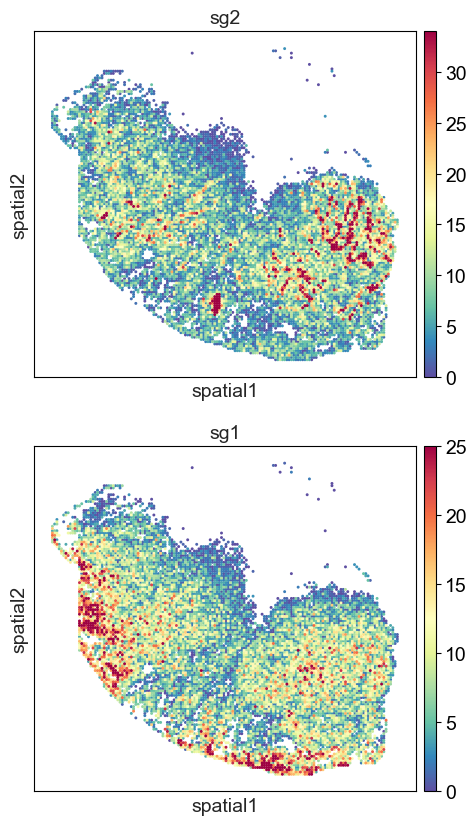

In [655]:
fig,axs = plt.subplots(2,1,figsize = (10,10))
sc.pl.spatial(ac,basis = 'spatial',color = ['sg2'],spot_size = 130,cmap = 'Spectral_r',vmax = 'p98',show = False,ax = axs[0])
sc.pl.spatial(ac,basis = 'spatial',color = ['sg1'],spot_size = 130,cmap = 'Spectral_r',vmax = 'p98' ,show = False,ax= axs[1])
# fig.savefig('./MainFigure/Fig4c.sg2sg1.pdf',bbox_inches = 'tight')
fig.show()

In [289]:
tmp_df = snv.var.copy()
tmp_df['chrom'] = tmp_df.index.map(lambda x: x.split('_')[0])
tmp_df['num'] = tmp_df.index.map(lambda x: str(int(x.split('_')[1].split(':')[0])//window_size))
snv.var['windows'] = tmp_df['chrom'] +'@'+ tmp_df['num']

In [618]:
import gseapy as gp
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 22].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()
geneList.index.to_frame()['gene_name'].to_csv('sg22.gene.csv',header=None,index=None)

In [378]:
pre_res = gp.prerank(rnk= geneList,gene_sets= "/storage/liuyi/data/gmt/h.all.v2023.1.Hs.symbols.gmt",threads=1,min_size=5,max_size=1000,permutation_num=1000, outdir=None, seed=6,verbose=True,)

2024-05-28 17:14:42,324 [WARNING] Duplicated values found in preranked stats: 89.58% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-28 17:14:42,325 [INFO] Parsing data files for GSEA.............................
2024-05-28 17:14:42,333 [INFO] 0047 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-05-28 17:14:42,333 [INFO] 0003 gene_sets used for further statistical testing.....
2024-05-28 17:14:42,334 [INFO] Start to run GSEA...Might take a while..................
2024-05-28 17:14:42,371 [INFO] Congratulations. GSEApy runs successfully................



In [379]:
pre_res.res2d

Name                              Term        ES       NES NOM p-val  \
0  prerank               HALLMARK_COMPLEMENT  0.737968  1.315022  0.117786   
1  prerank  HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.606644  1.218877  0.205977   
2  prerank              HALLMARK_P53_PATHWAY  0.513035  0.907866  0.628468   

  FDR q-val FWER p-val Tag %  Gene %  \
0  0.344168      0.253   2/5   8.85%   
1  0.325239      0.422  7/11  27.08%   
2  0.631358      0.868   3/5  30.73%   

                                   Lead_genes  
0                                 HSPA5;CXCL1  
1  CEBPD;NFKBIA;CXCL1;CXCL3;FOS;ZC3H12A;CCL20  
2                             FOS;SOCS1;ITGB4

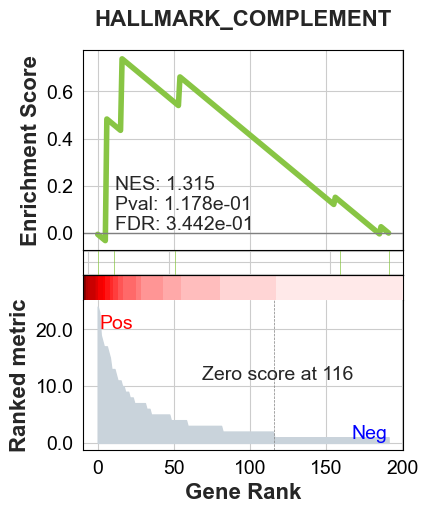

In [358]:
term = "HALLMARK_COMPLEMENT"
axs = pre_res.plot(terms= term, show_ranking=True) # v1.0.5

In [18]:
rna.uns['log1p']['base'] = None
sub_rna = rna[:,rna.var['highly_variable']].copy()

In [19]:
sc.tl.rank_genes_groups(sub_rna,groupby = 'cluster',method = 'wilcoxon')

ranking genes


/home/liuyi/miniconda3/envs/scanpy/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


In [20]:
result = sub_rna.uns["rank_genes_groups"]
groups = result["names"].dtype.names
# pd.DataFrame({group + "_" + key[:1]: result[key][group]for group in groups for key in ["names", "pvals"]})[:40]

In [21]:
norm_snv_gene_adata = snv_gene_adata.copy()

In [22]:
norm_snv_gene_adata.obs['UMI_counts'] = rna.obs['total_counts']
umi_per_cell = np.ravel(norm_snv_gene_adata.obs['UMI_counts'])
norm_snv_gene_adata.X = np.log1p(_normalize_data(norm_snv_gene_adata.X,umi_per_cell,after = 1e4))

In [25]:
from scipy.spatial.distance import pdist
from scipy.stats import ttest_ind
def euclidean_distance_matrix(matrix):
    distance_matrix = pdist(matrix,metric='euclidean')
    return distance_matrix

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    250 total control genes are used. (0:00:00)


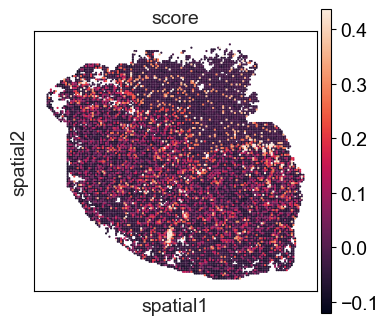

In [17]:
mac = ['CD68','CD14','MSR1','ITGAM','CX3CR1','CSF1R']
sc.tl.score_genes(rna,mac)
sc.pl.spatial(rna,basis = 'spatial',color = ['score'],spot_size = 130,vmax = 'p99')

computing score 'TAM'
    finished: added
    'TAM', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


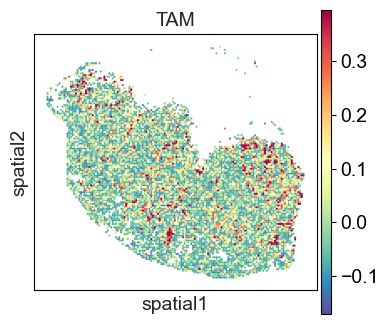

In [30]:
mac = ['CD68','CD14','MMP2','MMP9','VTCN1','CD163','MRC1']
sc.tl.score_genes(rna,mac,score_name='TAM')
sc.pl.spatial(rna[rna.obs['cluster'] != 'Normal'],basis = 'spatial',color = ['TAM'],spot_size = 130,vmax = 'p98',cmap = 'Spectral_r')

In [236]:
procon = ss.mul_rank_weight(ss_con, rank_cutoff=50, ret='value',transpose=False, include_self=False, nthreads=20)
procon = ss.weight_norm(procon, alpha=1)

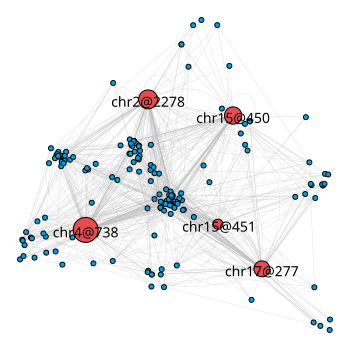

In [662]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 1].var_names
indices = [np.where(snv_gene_adata.var_names == gene)[0][0] for gene in inlist if gene in snv_gene_adata.var_names]
sub_con = procon[indices, :][:, indices]
g = ss.create_graph(sub_con, directed=True)
g.vs['name'] = inlist
visual_style = {}
visual_style["bbox"] = (300, 300) 
visual_style["margin"] = 20
visual_style["edge_color"] = "gray"
import igraph as ig
topn = 5
degrees = g.degree()
n = len(g.vs)
top_indices = sorted(range(n), key=lambda i: degrees[i], reverse=True)[:topn]
top_degrees = [degrees[i] for i in top_indices]
max_degree_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:topn]
labels = ["" for _ in range(len(g.vs))]
for idx in max_degree_indices:
    labels[idx] = g.vs[idx]["name"]
    
min_top_degree, max_top_degree = min(top_degrees), max(top_degrees)
node_sizes = [5] * n 
for idx in top_indices:
    if max_top_degree > min_top_degree: 
        size = ((degrees[idx] - min_top_degree) / (max_top_degree - min_top_degree) * 15) + 10  
    else:
        size = 25
    node_sizes[idx] = max(size, 5)
    
layout = g.layout("mds")   #"grid"  "graphopt" "davidson_harel"  "drl" "mds" "kk"
visual_style = {}
visual_style["bbox"] = (350, 350)
visual_style["edge_color"] = "gray"
visual_style['edge_arrow_size'] = 0.1  
ig.plot(g, layout=layout,
        vertex_size=node_sizes,edge_width = 0.2,
        vertex_color=['#E84B50' if idx in top_indices else '#00A1DF' for idx in range(n)],
        vertex_label=labels,
        **visual_style,target='./MainFigure/sg1.pdf')

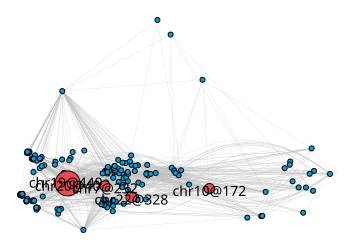

In [650]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
indices = [np.where(snv_gene_adata.var_names == gene)[0][0] for gene in inlist if gene in snv_gene_adata.var_names]
sub_con = procon[indices, :][:, indices]
g = ss.create_graph(sub_con, directed=True)
g.vs['name'] = inlist
visual_style = {}
visual_style["bbox"] = (300, 300) 
visual_style["margin"] = 20
visual_style["edge_color"] = "gray"
import igraph as ig
topn = 5
degrees = g.degree()
n = len(g.vs)
top_indices = sorted(range(n), key=lambda i: degrees[i], reverse=True)[:topn]
top_degrees = [degrees[i] for i in top_indices]
max_degree_indices = sorted(range(len(degrees)), key=lambda i: degrees[i], reverse=True)[:topn]
labels = ["" for _ in range(len(g.vs))]
for idx in max_degree_indices:
    labels[idx] = g.vs[idx]["name"]
    
min_top_degree, max_top_degree = min(top_degrees), max(top_degrees)
node_sizes = [5] * n 
for idx in top_indices:
    if max_top_degree > min_top_degree: 
        size = ((degrees[idx] - min_top_degree) / (max_top_degree - min_top_degree) * 15) + 10  
    else:
        size = 25
    node_sizes[idx] = max(size, 5)
    
layout = g.layout("mds")   #"grid"  "graphopt" "davidson_harel"  "drl" "mds" "kk"
visual_style = {}
visual_style["bbox"] = (350, 250)
visual_style["edge_color"] = "gray"
visual_style['edge_arrow_size'] = 0.1  
ig.plot(g, layout=layout,
        vertex_size=node_sizes,edge_width = 0.2,
        vertex_color=['#E84B50' if idx in top_indices else '#00A1DF' for idx in range(n)],
        vertex_label=labels,
        **visual_style,target='./MainFigure/sg2.pdf')

In [ ]:
#  sg2

In [663]:
total_gene = []
for win in ['chr15@450','chr15@451','chr2@2278','chr4@738','chr17@277']:
    node_index = g.vs.find(name=win).index
    neighbors = g.neighbors(node_index, mode='out')
    neighbors = g.vs[neighbors]['name']
    for i in neighbors:
        total_gene.extend(snv[:,snv.var['windows'] == i].var['gene_name'].drop_duplicates().values)

In [664]:
','.join(list(set(total_gene)))

'CXCL1,NOS2,AC091117.2,DUOXA1;DUOXA2,AL365226.2,TNFRSF6B,C10orf99,DUOXA1,RTEL1-TNFRSF6B;TNFRSF6B,PTGES2,AC243967.2,CIZ1,AL603756.1,CXCL3,MMP7,GHITM,AC098935.1,CEACAM5,AC243967.1,SORD,CXCL2,FAM3D-AS1,CCL20,C2CD4A,MHENCR,SLC25A25-AS1,PIGR,CXCL8,LCN2,PI3,DUOX2,ARFRP1,TMCC1,C2CD4B,CEACAM5;AC243967.1,FAM3D,C9orf16,CTNNA3,FAM3D;C3orf67,AC051619.6,AC087393.2'

In [520]:
total_gene = []
for i in neighbors:
    total_gene.extend(snv[:,snv.var['windows'] == i].var['gene_name'].drop_duplicates().values)

In [532]:
pd.DataFrame(total_gene).to_csv('chr4out.csv',index=None,header=None)

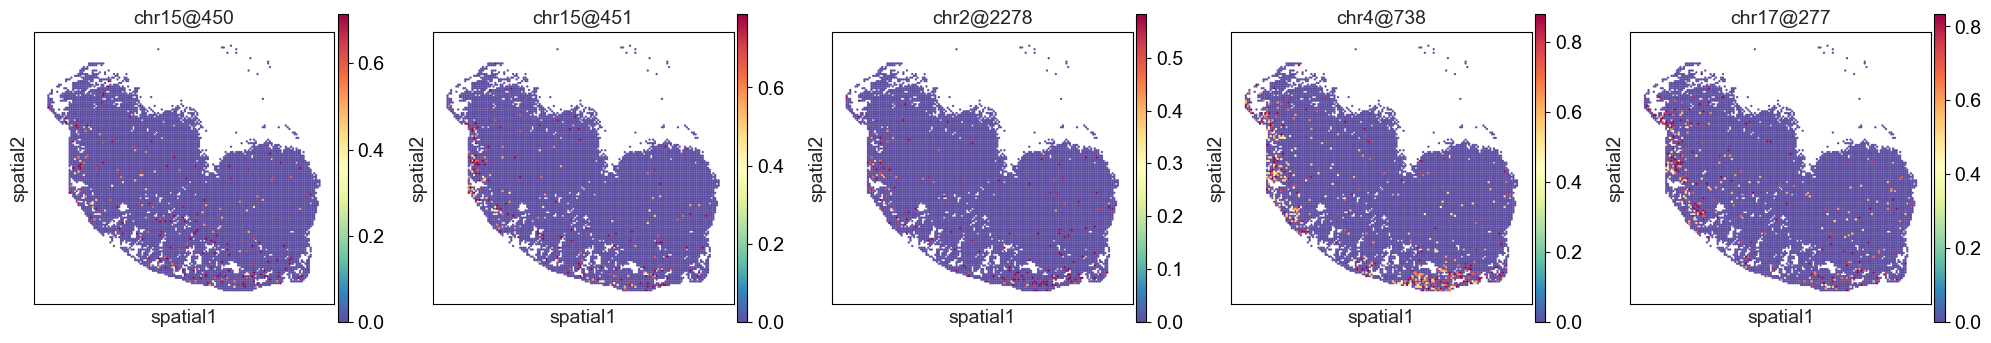

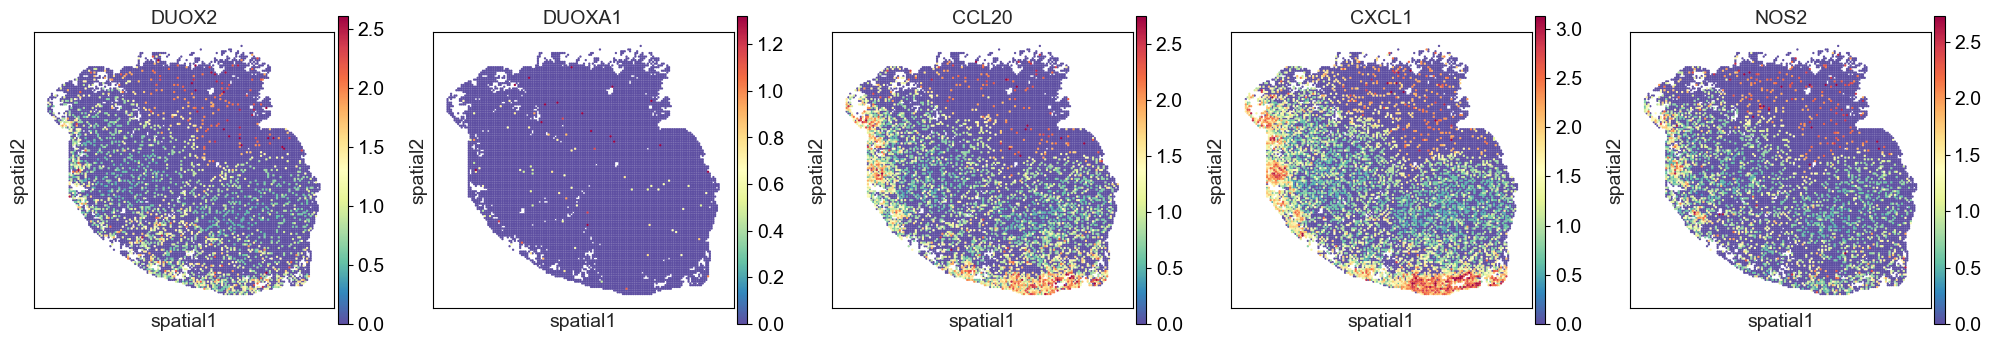

In [656]:
# DUOX2  CCL20     DUOXA1  NOS2 CXCL1
sc.pl.spatial(norm_snv_gene_adata,color = ['chr15@450','chr15@451','chr2@2278','chr4@738','chr17@277',],spot_size = 130,vmax = 'p99',cmap = 'Spectral_r',ncols = 5,save = 'sg2.snv.pdf')
sc.pl.spatial(rna,color = ['DUOX2','DUOXA1','CCL20',"CXCL1",'NOS2'],spot_size = 130,vmax = 'p99.9',cmap = 'Spectral_r',ncols = 5,save = 'sg2.rna.pdf')

In [676]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()

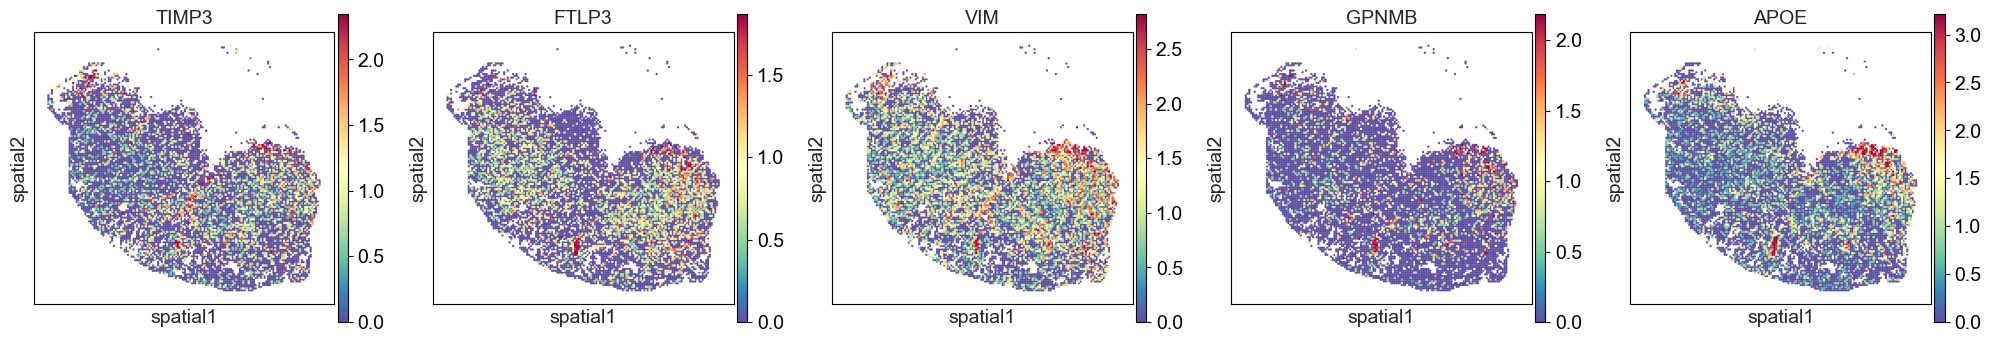

In [658]:
# DUOX2  CCL20     DUOXA1  NOS2 CXCL1
# sc.pl.spatial(norm_snv_gene_adata,color = ['chr22@328','chr20@40','chr10@172','chr7@232','chr19@449',],spot_size = 130,vmax = 'p99',cmap = 'Spectral_r',ncols = 5,save = 'sg2.snv.pdf')
sc.pl.spatial(rna[rna.obs['cluster'] != 'Normal'],color = ['TIMP3','FTLP3','VIM',"GPNMB",'APOE'],spot_size = 130,vmax = 'p99.5',cmap = 'Spectral_r',ncols = 5,save = 'sg2.rna.pdf')

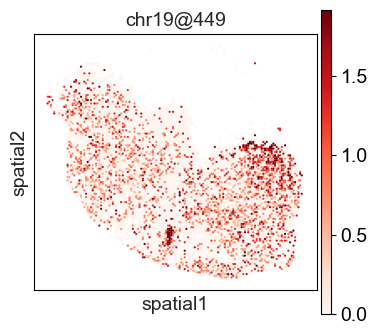

In [105]:
sc.pl.spatial(norm_snv_gene_adata,color = 'chr19@449',spot_size = 130,vmax = 'p99',cmap = 'Reds')

In [933]:
snvdftmp = snv.var.copy()
winsize = 10000
snvdftmp['chrom'] = snvdftmp['gene_ids'].apply(lambda x : x.split('_')[0])
snvdftmp['pos'] = snvdftmp['gene_ids'].apply(lambda x : str(int(x.split('_')[1].split(':')[0])//winsize))
snv.var['smallwindows'] = snvdftmp['chrom'] +'@' + snvdftmp['pos']

In [939]:
snv.obs['chr4'] = np.sum(snv[:,snv.var['smallwindows'] == 'chr4@116'].X,axis = 1)
snv.obs['chr4'] = snv.obs['chr4']/snv.obs['UMI_counts']

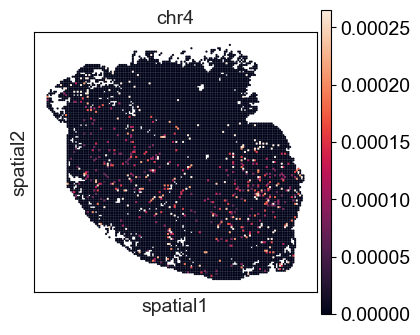

In [942]:
sc.pl.spatial(snv,color = 'chr4',spot_size = 130,vmax = 'p99',cmap = 'rocket')

In [ ]:
module_snv.var

In [ ]:
inlist = snv_gene_adata[:,snv_gene_adata.var['snv_group'] == 2].var_names
module_snv = snv[:,snv.var['windows'].isin(inlist)]
# module_snv = module_snv[:,~module_snv.var['ExonicFunc'].isin(['.','unknown','synonymous SNV'])]
module_snv = module_snv[:,module_snv.var['Func_L0']!='Intergenic']
module_snv = module_snv[:,~module_snv.var['gene_name'].apply(lambda x :  ';' in x)].copy()
geneList = module_snv.var['gene_name'].value_counts().to_frame()

In [735]:
import gseapy as gp
pre_res = gp.prerank(rnk= geneList,gene_sets= "/storage/liuyi/data/gmt/h.all.v2023.1.Hs.symbols.gmt",threads=1,min_size=5,max_size=1000,permutation_num=1000, outdir=None, seed=6,verbose=True,)

2024-05-29 13:30:00,325 [WARNING] Duplicated values found in preranked stats: 92.64% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-05-29 13:30:00,327 [INFO] Parsing data files for GSEA.............................
2024-05-29 13:30:00,336 [INFO] 0038 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-05-29 13:30:00,338 [INFO] 0012 gene_sets used for further statistical testing.....
2024-05-29 13:30:00,340 [INFO] Start to run GSEA...Might take a while..................
2024-05-29 13:30:00,438 [INFO] Congratulations. GSEApy runs successfully................



In [737]:
pre_res.res2d

Name                                        Term        ES       NES  \
0   prerank                   HALLMARK_MTORC1_SIGNALING  0.831563  1.505695   
1   prerank                         HALLMARK_COMPLEMENT  0.701843  1.495222   
2   prerank  HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION  0.598917  1.374909   
3   prerank                        HALLMARK_COAGULATION  0.622902  1.371446   
4   prerank            HALLMARK_ESTROGEN_RESPONSE_EARLY -0.561947 -1.361112   
5   prerank                         HALLMARK_MYOGENESIS  0.630631  1.277014   
6   prerank                          HALLMARK_APOPTOSIS  0.602077  1.196716   
7   prerank                    HALLMARK_APICAL_JUNCTION   0.59292  1.098025   
8   prerank                     HALLMARK_UV_RESPONSE_DN  0.532704  1.052699   
9   prerank                         HALLMARK_GLYCOLYSIS  0.517699  0.951019   
10  prerank                  HALLMARK_KRAS_SIGNALING_UP  0.440538  0.869412   
11  prerank                            HALLMARK_HYPOXIA  0.450774  0.821688   

   NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0   0.013333  0.142055      0.119    3/5  11.26%   
1   0.017562  0.079777      0.131  11/14  23.38%   
2   0.035389  0.241562      0.463  19/24  37.66%   
3   0.063136  0.187605      0.475   9/16  17.75%   
4   0.109827  0.098174   0.164539    5/5  45.45%   
5   0.140523  0.311903      0.732    4/9  16.45%   
6   0.244199  0.423077      0.886    6/8  35.93%   
7   0.367971   0.56675      0.969    5/5  41.99%   
8   0.432671  0.586234      0.988    3/8  16.45%   
9   0.553398  0.697923      0.999    5/5  49.35%   
10   0.69011  0.752686        1.0    6/8  45.02%   
11   0.72973  0.748737        1.0    4/5  49.35%   

                                           Lead_genes  
0                                   TOMM40;SHMT2;LGMN  
1   C1R;GNAI2;LGMN;CTSD;CTSB;CTSL;SERPING1;TIMP2;L...  
2   PCOLCE;TIMP3;SPARC;COL6A2;MMP2;COL5A1;COL3A1;C...  
3   C1R;TIMP3;SPARC;LGMN;MMP2;CTSB;SERPING1;LRP1;GNB2  
4                        SVIL;ADCY9;AFF1;SEMA3B;RAB31  
5                          SPARC;COL6A2;COL3A1;COL1A1  
6                     TIMP3;MMP2;TIMP2;LUM;DCN;IGFBP6  
7                        GNAI2;MMP2;PECAM1;VCAN;FSCN1  
8                                COL3A1;COL1A2;COL1A1  
9                          COL5A1;DCN;VCAN;CXCR4;EXT1  
10                ACE;ST6GAL1;GPNMB;PECAM1;GYPC;CXCR4  
11                              COL5A1;DCN;CXCR4;EXT1

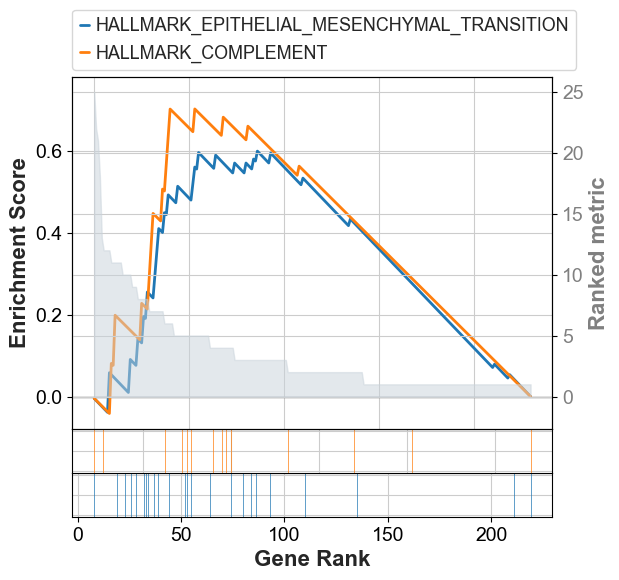

In [745]:
term = ["HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION",'HALLMARK_COMPLEMENT']
axs = pre_res.plot(terms= term, show_ranking=True)
axs.savefig('./MainFigure/Figure4E.pdf',bbox_inches = 'tight')